In [184]:

import pandas as pd
import pymysql
from sql_info import USER, PASSWORD, DB_NAME # 별도의 파일로 MySQL 접속 관리
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc 
import seaborn as sns 

# sns.set_theme('darkgrid') # 글씨 깨진다
sns.set(font_scale = 1.25)
sns.set_palette("pastel")

# 한글 깨지는 현상 수정
f_path = "C:/windows/Fonts/malgun.ttf"
font_manager.FontProperties(fname=f_path).get_name()
rc('font', family='Malgun Gothic')


import warnings
warnings.filterwarnings(action = 'ignore')

pd.set_option('display.max_colwidth', 100) # 데이터의 길이가 길면 ...되는 부분을 없앰


In [185]:
# 22년 1월 1일부터 데이터가 수집되었음 - 조회시 참고
def read_sql_weeks(weeks = 4, read_all = False):

    db = pymysql.connect(host='localhost', user = USER, passwd = PASSWORD, db = DB_NAME, charset = 'utf8')

    # 일단 메모리 측면에서 생각해보면 당연히 쿼리를 날려서 일부 데이터만 메모리에 올리는 쪽이 훨씬 효율적일 것

    end_date = datetime.today().date()
    
    if read_all:
        start_date = '2022-01-01'
    else:
        start_date = end_date - timedelta(weeks = weeks)
    
    query1 = f"SELECT * FROM reports WHERE date >= '{start_date}' and date <= '{end_date}' ORDER BY date DESC"

#     query1 = (f"SELECT r.company as company, r.date as date, r.written_by as written_by, \
#             c.code as company_code, c.category as category, r.reports_idx as reports_idx\
#             FROM reports r \
#             JOIN companies c \
#             ON r.company = c.company \
#             WHERE date >= '{start_date}' and date <= '{end_date}'")

    query2 = (f"SELECT * \
                FROM companies")

    reports_df = pd.read_sql_query(query1, db)
    companies_df = pd.read_sql_query(query2, db)
    # reports_df.drop_index()

    db.close()

    return reports_df, companies_df, start_date, end_date


# 가공하는 부분을 따로 떼어냄
def processing_df(reports_df, companies_df, URL = False):
    
    # date는 object로 불러오므로 날짜 데이터로 변환
    reports_df['date'] = pd.to_datetime(reports_df['date'])
    
    # df에 레포트 보고서 링크와 기업 정보 링크를 넣고 싶다면 추가
    if URL:
        
        HK_URL =  "http://hkconsensus.hankyung.com/apps.analysis/analysis.downpdf?report_idx="
        reports_df['reports_link'] = HK_URL + reports_df['reports_idx']
        
        # companies_df 항목 수정 : 기업 코드 제거 & 해당 종목 네이버증권 URL 첨부

        NAVER_COMPANY_INFO_URL = "https://finance.naver.com/item/main.naver?code="
        companies_df['companies_info'] = NAVER_COMPANY_INFO_URL + companies_df['code']
        
    
    # 필요없는 column들 제거 - 기업 코드는 혹시 몰라 살려두지만 레포트 인덱스는 보고서 조회 외에는 필요 없어보여 제거
    reports_df.drop('reports_idx', axis = 1, inplace = True)
    # companies_df.drop('code', axis = 1, inplace = True)
    
    # 인덱스 초기화
    reports_df.reset_index()



# 필요하다면 merge를 해준다
def merge_df(reports_df, companies_df):
    total_df = pd.merge(reports_df, companies_df, on = 'company')
    total_df['YearMonth'] = total_df['date'].dt.strftime('%Y-%m')
    return total_df
    

In [186]:

reports_df, companies_df, start_date, end_date = read_sql_weeks(weeks = 20,
                                                                read_all = True)
processing_df(reports_df, companies_df, URL = True)

total_df = merge_df(reports_df, companies_df) # 아래 코드 진행은 merge_df로 진행함
# total_df.head(10)

In [187]:
# 폰트 정리
suptitle_dict = {
    'color' : 'darkred',
    'weight' : 'bold',
    'size' : 30
}

In [188]:
category_lst = total_df['category'].value_counts()


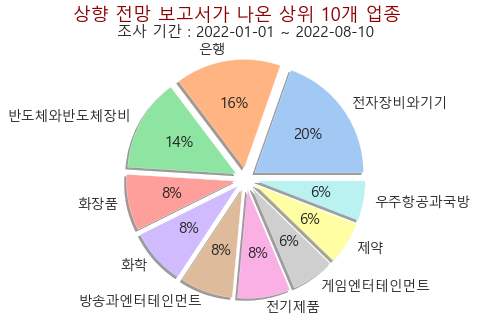

In [191]:
# 시각화
# 1. 가장 많은 상향 보고서가 나온 산업 num개를 보여줌(기본 10개)
def ShowCategory(num = 10):
        colors = sns.color_palette('pastel')

        fig = plt.figure(figsize = (10, 5), facecolor = 'white')
        plt.pie(category_lst.values[0:num], 
                labels = category_lst.index[0:num],
                colors = colors,
                autopct = "%.0f%%", # 부채꼴 안에 표시되는 숫자의 형식
                explode = [.1] * num,
                shadow = True,
                wedgeprops = {'linewidth' : 0.3}
                )
         
        fig.suptitle(f'상향 전망 보고서가 나온 상위 {num}개 업종', fontdict = suptitle_dict)

        plt.title(f'조사 기간 : {start_date} ~ {end_date}')
        plt.show()

ShowCategory()

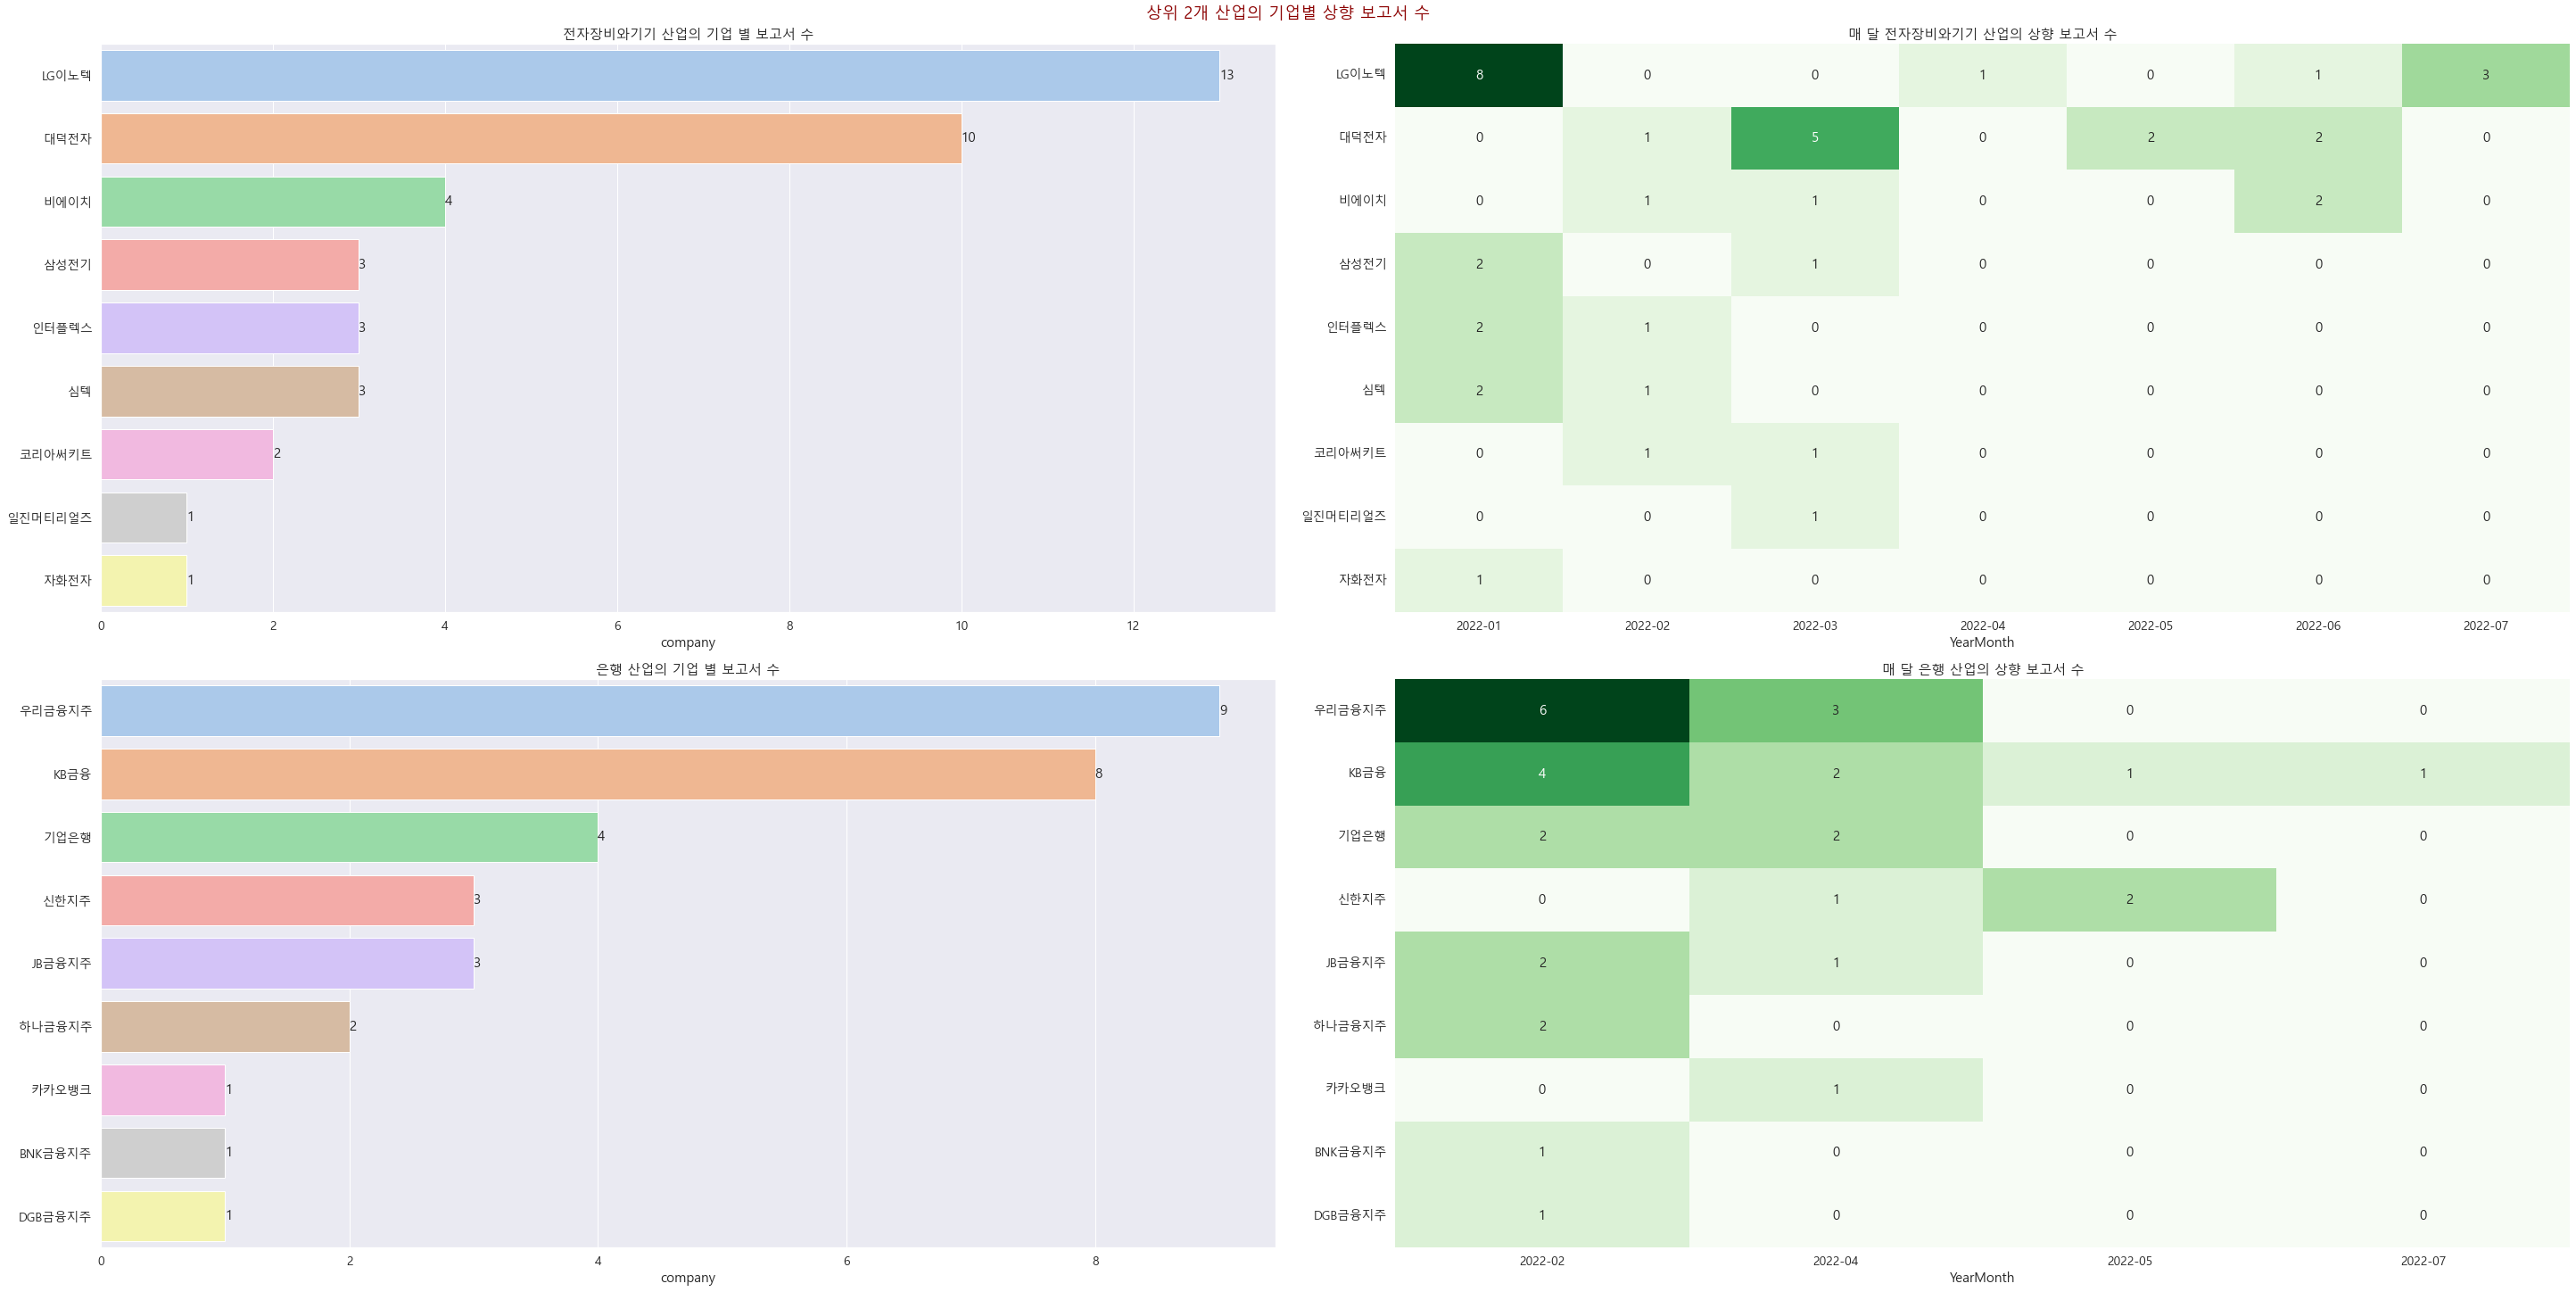

In [190]:
# 4. 두 그래프 동시에 띄우기 (각각의 코드는 삭제)

n = 2
fig, ax = plt.subplots(n, 2, figsize = (40, 20), constrained_layout = True)


fig.suptitle(f'상위 {n}개 산업의 기업별 상향 보고서 수', fontdict = suptitle_dict)
for i in range(n):
    # 왼쪽 : 막대 그래프
    cp_lst = total_df[total_df['category'] == category_lst.index[i]]['company'].value_counts()
    
    ax[i][0].title.set_text(f"{category_lst.index[i]} 산업의 기업 별 보고서 수")
    sns.barplot(x = cp_lst, y = cp_lst.index, ax = ax[i][0])
    ax[i][0].bar_label(ax[i][0].containers[0]) # 갯수 표시
    
    # 오른쪽 : 히트맵
    heatmap_df = total_df[total_df['category'] == category_lst.index[i]][['company', 'YearMonth']]
    order = cp_lst.index
    
    heatmap_df = heatmap_df.groupby(['company', 'YearMonth']).size() # Series
    heatmap_df = heatmap_df.reset_index() # 오; to_frame 없이 reset_index만 해줘도 잘 나오는듯
    heatmap_df = heatmap_df.rename(columns = {0 : 'counts'})
    heatmap_df = heatmap_df.pivot('company', 'YearMonth', 'counts')

    heatmap_df = heatmap_df.fillna(0)
    # 
    heatmap_df = heatmap_df.loc[order]
    ax[i][1].title.set_text(f"매 달 {category_lst.index[i]} 산업의 상향 보고서 수")
    
    sns.heatmap(heatmap_df, cmap = 'Greens', annot = True, ax = ax[i][1], cbar=False)
    

company  YearMonth
BGF리테일   2022-04      1
         2022-05      4
BNK금융지주  2022-02      1
CJ ENM   2022-02      1
CJ제일제당   2022-02      1
                     ..
현대해상     2022-04      1
         2022-05      1
         2022-06      1
효성화학     2022-01      1
후성       2022-02      1
Length: 281, dtype: int64

TypeError: heatmap() missing 1 required positional argument: 'data'

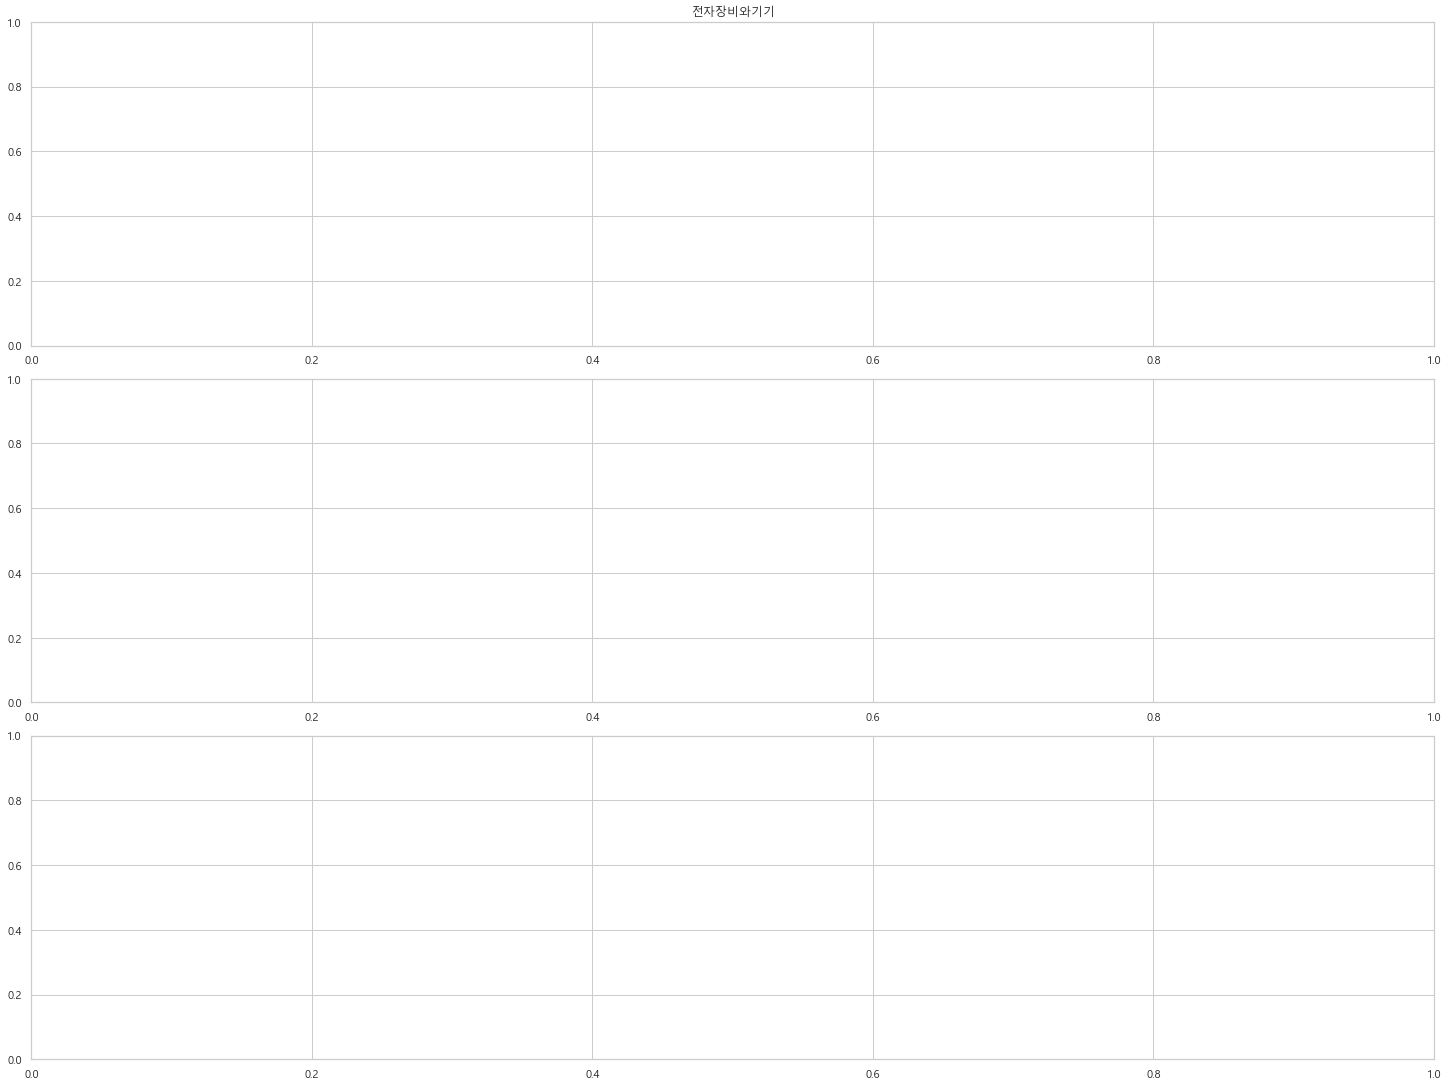

In [162]:
# 3. 위 막대그래프를 히트맵으로 바꾸고, 보고서가 나온 날짜
fig, axes = plt.subplots(3, 1, figsize = (20, 15), 
                         constrained_layout = True)

for i in range(3):
    cp_lst = total_df[total_df['category'] == category_lst.index[i]][['company', 'date']].value_counts()
    axes[i].title.set_text(category_lst.index[i])
    # axes[i][0] = sns.barplot(x = cp_lst, y = cp_lst.index)
    sns.heatmap(x = cp_lst, y = cp_lst.index, ax = axes[i])
    axes[i].bar_label(axes[i].containers[0])